# Probabilistic Matrix Factorization

["about article of PMF - by Ruslan and Andriy"](https://papers.nips.cc/paper/2007/file/d7322ed717dedf1eb4e6e52a37ea7bcd-Paper.pdf)

In [30]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

In [31]:
"setting parameters"
dimension = 10
stdv = 0.01
stdv_U = 0.1
stdv_V = 0.1
learning_rate = 0.005
momentum = 0.5
parameters = {}
epoch = 100

# parameters['moment_U'] = moment_U
# parameters['moment_V'] = moment_V

### import_data
The code "import_data" loads the data set about Items following the "path". The data set is recorded on users, items, ratings, etc.<br>
Among these data, this code extracts data about users, items and ratings.<br>
$----------$<br>
Return

data_sort : which remove and sort in order of users from data about users, items and ratings<br>
n_User and n_Item : the number of Users (or Items)

In [32]:
def import_data(path):
    data = pd.read_csv(path, sep='\t', names=['User', 'Item', 'Rating', 'Timestamp'], header=None)
    data = data.drop('Timestamp', axis=1)
    
    data_pure = data.drop_duplicates(['User','Item'], keep = 'last')
    
    data_sort = data_pure.sort_values(['User', 'Item', 'Rating'])
    
    n_User = len(data_sort.User.unique())
    n_Item = len(data_sort.Item.unique())
    
    return data_sort, n_User, n_Item

### make_R
The code "make_R" makes a matrix about ratings of data.<br>
N : users, M : items (in this code - movies)<br>
$----------$<br>
Return

R : the preference matrix $N \times M$

In [33]:
def make_R(data):
    R = data.pivot(index ='User', columns = 'Item', values = 'Rating')
    R.fillna(0, inplace = True)
    R = R.values
    return R

### make_U_V
The code "make_U_V" makes matrices U and V.<br>

U is $D \times N$ , and its transpose is user coefficient matrix<br>
V is $D \times M$ , factor matrix

also,<br>
$P(U\mid\sigma_U^2) = \prod_{i=1}^N \mathcal{N}(U_i\mid0,\sigma_U^{2}\mathbf{I})$<br>
$P(V\mid\sigma_V^2) = \prod_{i=1}^M \mathcal{N}(V_i\mid0,\sigma_V^{2}\mathbf{I})$

and saves them in dictionary (named "parameters")<br>
$----------$<br>
Return

parameters

In [34]:
def make_U_V(n_User, n_Item, stdv_U, stdv_V, dimension, parameters):
    U = stdv_U*np.random.randn(dimension, n_User)
    V = stdv_V*np.random.randn(dimension, n_Item)
    parameters['U'] = U
    parameters['V'] = V
    return parameters

### RMSE_calculation
The code "RMSE_calculation" calculates the root mean square error between two data sets.<br>
Denotes original_data is R and predict_data is R* then,<br>

$RMSE = \sqrt{\frac{\sum_{i=1}^N\sum_{j=1}^M\mathrm{I_{i,j}}(R_{i,j} - R*_{i,j})^2}{\sum_{i=1}^N\sum_{j=1}^M\mathrm{I_{i,j}}}}$<br>
$----------$<br>
Return<br>

np.sqrt(mse) : RMSE

In [35]:
def RMSE_calculation(original_data, predict_data):
    xi, yi = original_data.nonzero()
    error = 0
    count = 0
    for x, y in zip(xi,yi):
        error += pow(original_data[x,y]-predict_data[x,y], 2)
        count+=1
    mse = error/count
    return np.sqrt(mse)

### gradient
The code "gradient" gives a feedback to matrix U and V by using "gradient descent" method.<br>
Finding values of U and V which maximize the log posterior over items and user features is equivalent to minimizing "sum of squared errors". (denoted "E")<br>
So,by "gradient descent" on "E" with learning rate and momentum to find those values.<br>

log-posterior :<br>$\ln p(U,V \mid R,\sigma^2,\sigma_V^2,\sigma_U^2) = -\frac{1}{2\sigma^2}\sum_{i=1}^N\sum_{j=1}^M\mathrm{I_{i,j}}(R_{i,j}-{U_{i}^T}V_j)^2 -\frac{1}{2\sigma_U^2}{\sum_{i=1}^N}{U_{i}^T}U_i -\frac{1}{2\sigma_V^2}{\sum_{j=1}^M}{V_{j}^T}V_j -\frac{1}{2}((\sum_{i=1}^N\sum_{j=1}^M\mathrm{I_{i,j}})\ln\sigma^2 +\mathrm{ND}\ln\sigma_U^2 + \mathrm{MD}\ln\sigma_V^2) + \mathrm{C}$<br>

sum of squared errors :<br>
$E = \frac{1}{2}\sum_{i=1}^N\sum_{j=1}^M\mathrm{I_{i,j}}(R_{i,j}-{U_{i}^T}V_j)^2 + \frac{\lambda_U}{2}\sum_{i=1}^N\| U_i \|_{Fro}^2 +\frac{\lambda_V}{2}\sum_{j=1}^M\| V_j \|_{Fro}^2$<br>
$----------$<br>
Return<br>

parameters : including the updated U and V

In [1]:
def gradient(parameters, i, j, R, stdv, stdv_U, stdv_V, learning_rate, moment_U, moment_V):
    U = parameters['U']
    V = parameters['V']
    
    UV_mean = np.dot(np.array([U[:,i]]), np.array([V[:,j]]).T)
    difference = R[i,j] - UV_mean
    lambda_U = (stdv/stdv_U)**2
    lambda_V = (stdv/stdv_V)**2
    copy_U = U.copy()
    
    learning_U = (learning_rate*(difference[0,0]*V[:,j] - lambda_U*np.abs(U[:,i])))
    learning_V = (learning_rate*(difference[0,0]*copy_U[:,i] - lambda_V*np.abs(V[:,j])))
    
    U_learn = np.mean(learning_U)
    V_learn = np.mean(learning_V)
    if not (U_learn>0):
        moment_U[i,j]=0.0
    if not (V_learn>0):
        moment_V[i,j] = 0.0
    moment_U[i,j] = momentum*moment_U[i,j] + U_learn
    moment_V[i,j] = momentum*moment_V[i,j] + V_learn
    
    U[:,i] += moment_U[i,j]
    V[:,j] += moment_V[i,j]

    parameters['U'] = U
    parameters['V'] = V

    return parameters

### train_and_test
The code "train_and_test" updates U and V using "gradient" function for all User and Item features which are rated.<br>

And makes approximation matrix $\hat{R} = {U^T}V$ which follows<br>
$p(R \mid U,V,\sigma^2) = \prod_{i=1}^N\prod_{j=1}^M[\mathcal{N}(R_{i,j} \mid {U_{i}^T}V_j,\sigma^2)]^{\mathrm{I_{i,j}}}$<br>

Finally, compute RMSE of R and $\hat{R}$ using "RMSE_calculation" function.<br>
$----------$<br>
Return<br>

costs : RMSE of train data sets<br>
test_costs : RMSE of test data sets<br>
parameters : the dictionary named "parameters"

In [37]:
def train_and_test(parameters, epoch, n_User, n_Item, R, R_test):
    costs=[]
    test_costs = []
    for i in range(epoch):
        for j in range(n_User):
            for k in range(n_Item):
                if R[j,k]>0:
                    gradient(parameters, j, k, R, stdv, stdv_U, stdv_V, learning_rate, moment_U, moment_V)
        U = parameters['U']
        V = parameters['V']
        R_predict_mean = np.dot(U.T,V)
        R_predict = np.random.normal(R_predict_mean, stdv)

        cost = RMSE_calculation(R, R_predict)
        cost_test = RMSE_calculation(R_test, R_predict)
        costs.append(cost)
        test_costs.append(cost_test)
        if (i%10 == 0):
            print("epoch: %d ... RMSE: %f ... test_RMSE: %f" %(i, cost, cost_test))
    return costs, test_costs, parameters

### Code Execution
Prints the results of train data sets and test data sets.<br>
Then, plots of each RMSE of train and test sets.<br>
Finally, prints out the matrix U and V forming approximation matrix $\hat{R}$.

epoch: 0 ... RMSE: 3.687756 ... test_RMSE: 3.716999
epoch: 10 ... RMSE: 0.971339 ... test_RMSE: 1.139582
epoch: 20 ... RMSE: 0.957613 ... test_RMSE: 1.112483
epoch: 30 ... RMSE: 0.954191 ... test_RMSE: 1.106275
epoch: 40 ... RMSE: 0.952757 ... test_RMSE: 1.103928
epoch: 50 ... RMSE: 0.951966 ... test_RMSE: 1.102795
epoch: 60 ... RMSE: 0.951520 ... test_RMSE: 1.102378
epoch: 70 ... RMSE: 0.951300 ... test_RMSE: 1.102114
epoch: 80 ... RMSE: 0.950987 ... test_RMSE: 1.101766
epoch: 90 ... RMSE: 0.950920 ... test_RMSE: 1.101647


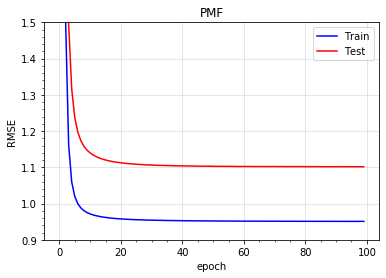

----------
[[0.65444709 0.54165984 0.62177568 ... 0.80745093 0.76629681 0.61099279]
 [0.61895604 0.837638   0.63316456 ... 0.56759739 0.58746515 0.71654065]
 [0.68120123 0.63570479 0.67008806 ... 0.65511438 0.68567089 0.48637497]
 ...
 [0.59425411 0.69840647 0.55658057 ... 0.72729759 0.72607454 0.69271271]
 [0.52930018 0.67642467 0.58070979 ... 0.7325426  0.70854044 0.68239102]
 [0.67690536 0.57069418 0.48992364 ... 0.62551137 0.54157237 0.58921045]]
----------
[[0.51606755 0.59119588 0.55325994 ... 0.2023237  0.54878367 0.48830432]
 [0.77358359 0.43134845 0.55234047 ... 0.40636664 0.64544949 0.39921125]
 [0.58839211 0.70574575 0.59518904 ... 0.39947845 0.81878338 0.4943232 ]
 ...
 [0.55136493 0.68123125 0.52548661 ... 0.14804481 0.49042246 0.44166455]
 [0.44335004 0.58108389 0.54814803 ... 0.26410434 0.6109842  0.61995511]
 [0.73446206 0.57349849 0.51946379 ... 0.32154171 0.49174606 0.47619723]]


In [38]:
data_sort, n_User, n_Item = import_data("../ml-100k/u1.base")
test_data_sort, test_n_User, test_n_Item = import_data("../ml-100k/u1.test")
R = make_R(data_sort)
R_test = make_R(test_data_sort)

moment_U = np.zeros(R.shape)
moment_V = np.zeros(R.shape)

make_U_V(n_User, n_Item, stdv_U, stdv_V, dimension, parameters)

costs, test_costs, parameters = train_and_test(parameters, epoch, n_User, n_Item, R, R_test)

plt.ylim([0.90,1.5])
plt.plot(costs, 'b', label='Train')
plt.plot(test_costs, 'r', label='Test')
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.title('PMF')
plt.minorticks_on()
plt.grid(b=True, which = 'major', color = '#666666', linestyle = '-', alpha = 0.2)
plt.legend()

plt.show()
print('----------')
print(parameters['U'])
print('----------')
print(parameters['V'])